# Import the necessary modules

In [5]:
%matplotlib inline
import sys
import os.path
import pandas as pd
import seaborn as sns; sns.set(); sns.set_style("ticks", {'axes.spines.right': False,
                                                          'axes.spines.top': False})
import matplotlib.pyplot as plt
font = {'size'   : 10}
plt.rc('font', **font)
import numpy as np
from scipy import stats
from scipy import optimize

# make sure we find the right python module
sys.path.append(os.path.join(os.path.dirname(''),'..','src'))

import covid_inference; import covid_models

# Defining models as classes

In this code, models used to perform inference on data are defined as classes. They take the data as input, and contain methods which calculate the log likelihood, log likelihood gradient, and log likelihood hessian. The table below indicates which methods are needed to perform each of the algorithms.

|                         | Random Walk | MALA     | smMALA   |
| :--------               | :---------: | :------: | :------: |
| log_likelihood          | &#10003;    | &#10003; | &#10003; |
| log_likelihood_gradient |             | &#10003; | &#10003; |
| log_likelihood_hessian  |             |          | &#10003; |

<div class="alert alert-block alert-info">
    <b>Tip:</b> Look in <b>/src/covid_models.py</b> for an idea of how to construct your own model classes
</div>

# Negative Binomial Regression

We will test out our algorithms on some synthetic negative binomial data.

#### Generate and visualise synthetic data

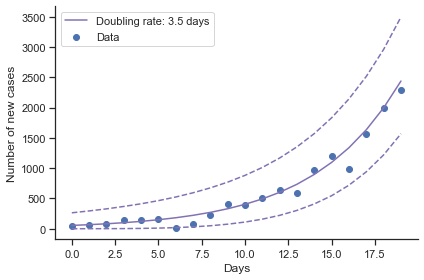

In [6]:
# generate data
number_of_days = 20
regression_coefficients = np.array([4,0.2,100])
days = np.arange(number_of_days)
mu = np.exp(regression_coefficients[0])*np.exp(regression_coefficients[1]*days)
od = regression_coefficients[2]*np.ones(number_of_days)
r=mu/(od-1)
p = 1/od
data = stats.nbinom.rvs(r,p)

doubling_time = np.log(2.0)/regression_coefficients[1]

# visualise with confidence intervals
plt.scatter(days,data,label='Data')
plt.plot(days,mu,'-',c='m',label='Doubling rate: {:.1f} days'.format(doubling_time))
plt.plot(days,stats.nbinom.ppf(0.025,r,p),linestyle='--',c='m')
plt.plot(days,stats.nbinom.ppf(0.975,r,p),linestyle='--',c='m')
plt.xlabel('Days')
plt.ylabel('Number of new cases')
plt.legend()
plt.tight_layout()

# Use the negative binomial model class to perform Bayesian inference 

We can do a similar type of visualisation as above, using uncertainty quantification from the Markov chains

# Random Walk Metropolis
First we take the data and minimise the negative log-likelihood for initialisation of our chain. Then we run the random walk algorithm twice. The first time gives us an idea of the correlation structure, which we use for the second run in order to sample as effectively as possible.

In [7]:
negative_binomial_test = covid_models.negative_binomial_data(data)
negative_binomial_test.log_likelihood(np.array([1,1,2]),negative=True)

531887829.4337983

In [11]:
negative_binomial_test = covid_models.negative_binomial_data(data)
number_of_samples = 1000000
initial_position = np.array([ 3.13897153,  0.3940096 , 56.45188604])
step_size = 0.02
thinning_rate = 1

initial_position = optimize.minimize(negative_binomial_test.log_likelihood,
                                     np.array([3,0.4,20]),method='Nelder-Mead',args=(True)).x
print(initial_position)

# first run
print('First Run')
output = covid_inference.random_walk(negative_binomial_test,
                                     number_of_samples,
                                     initial_position,
                                     step_size,
                                     thinning_rate=thinning_rate)

# obtain correlation structure for proposal covariance matrix
proposal_covariance = np.cov(output.T)
step_size = 2.0

#second run
print('\nSecond Run')
output = covid_inference.random_walk(negative_binomial_test,
                                     number_of_samples,
                                     initial_position,
                                     step_size,
                                     proposal_covariance=proposal_covariance,
                                     thinning_rate=thinning_rate)

print('Coefficient 1 mean:',np.mean(output[:,0]))
print('Coefficient 2 mean:',np.mean(output[:,1]))
print('Coefficient 3 mean:',np.mean(output[:,2]))

[ 3.82541444  0.20805497 47.42680347]
First Run


KeyboardInterrupt: 

# Visualise output

#### Markov  chains

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(6,4))
for i in range(output.shape[1]):
    ax[i].plot(output[:,i])
    ax[i].set_xlabel('$\\beta_{}$'.format(i))
plt.tight_layout()
plt.show()

#### Pair Grid

In [ ]:
g = sns.PairGrid(pd.DataFrame(output[:-1:10],columns=['$x_1$','$x_2$','$x_3$']))
g = g.map_upper(sns.scatterplot,size=2,color='#20948B')
g = g.map_lower(sns.kdeplot,color="#20948B",shade=True,shade_lowest=False)
g = g.map_diag(sns.distplot,color='#20948B')
plt.tight_layout()

#### Time series

In [ ]:
thinning_rate = 1
ys = np.zeros((number_of_samples//thinning_rate,number_of_days))

plt.figure(figsize=(8,6))
for i in range(0,number_of_samples,thinning_rate):
    mu = np.exp(output[i,0])*np.exp(output[i,1]*days)
    od = output[i,2]*np.ones(number_of_days)
    p = 1/od
    r = mu/(od-1)
    ys[i//thinning_rate] = np.random.negative_binomial(r,p)

mu = np.exp(np.mean(output[:,0]))*np.exp(np.mean(output[:,1])*days)
lower_error = np.percentile(ys,2.5,axis=0)
upper_error = np.percentile(ys,97.5,axis=0)

plt.plot(days,mu,linestyle='-',c='m')
plt.plot(days,lower_error,linestyle='--',c='m')
plt.plot(days,upper_error,linestyle='--',c='m')
plt.scatter(days,data,label='Data')
plt.xlabel('Days')
plt.ylabel('Number of new cases')
plt.title('Synthetic Data with Bayesian Confidence intervals')
plt.tight_layout()